# Simple VQE Coding Exercise: H2 Molecule

This notebook guides you through a simplified VQE workflow to find the ground state energy of the Hydrogen molecule (H2). We will use the latest Qiskit 1.x features and the Qiskit Runtime primitives.

**Setup:**
You will need `qiskit`, `qiskit-ibm-runtime`, `numpy`, and `scipy`.
*(We will assume the Hamiltonian is given to simplify the chemistry part)*

`pip install qiskit qiskit-ibm-runtime numpy scipy`

In [1]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from scipy.optimize import minimize

### Introduction: From QAOA to VQE

In Week 6, we explored **QAOA** to solve the Max-Cut problem. There, we "invented" a Hamiltonian ($H_C$) to represent a classical optimization problem. 

Now, in **Week 7**, we generalize this to **VQE (Variational Quantum Eigensolver)**. Instead of inventing a Hamiltonian, we use one given to us by **nature**—specifically, the Hamiltonian describing a molecule's electrons.

#### The Challenge: Mapping Fermions to Qubits
Electrons are **fermions** (they follow the Pauli Exclusion Principle), while quantum computers use **qubits**. To simulate chemistry, we must map one to the other. 

* **Jordan-Wigner Mapping:** The standard method used. It maps **1 Orbital $\rightarrow$ 1 Qubit**.
    * $|0\rangle$: Orbital is empty.
    * $|1\rangle$: Orbital contains an electron.

Once mapped, the molecular energy is represented as a sum of Pauli terms (like `XX`, `ZZ`, `IZ`), weighted by coefficients ($c_i$).

$$ H = \sum_i c_i P_i $$

**In the following task**, we provide a pre-calculated Hamiltonian for the $H_2$ molecule at its equilibrium bond distance.

## Task 1: Define the Problem (Hamiltonian)

We will skip the complex chemistry mapping (PySCF/Qiskit Nature) for this simple exercise. Instead, we manually define the Hamiltonian for an H2 molecule mapped to 2 qubits (using a parity mapping or tapering to reduce from 4 to 2 qubits).

The Hamiltonian is a sum of Pauli terms:
$H = -1.05 \cdot II + 0.39 \cdot IZ - 0.39 \cdot ZI - 0.01 \cdot ZZ + 0.18 \cdot XX$

In [2]:
# 1. Define the Observable (Hamiltonian) using SparsePauliOp
hamiltonian = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

print("Hamiltonian defined:")
print(hamiltonian)

Hamiltonian defined:
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05237325+0.j,  0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,
  0.1809312 +0.j])


### Note: The Ansatz (The "Guess")

Since we don't know the ground state wavefunction, we create a "guess" circuit called an **Ansatz**. This circuit has tunable parameters ($\theta$). By changing $\theta$, we explore different quantum states.

There are two main types of Ansatz:
1.  **Chemistry-Inspired (e.g., UCCSD):** Mimics actual electron excitations. Highly accurate but creates very deep circuits (bad for current hardware).
2.  **Hardware Efficient (e.g., EfficientSU2):** Uses standard gates available on the hardware. It is heuristic (trial and error) but much shallower and easier to run on noisy devices.

**In the following task**, we use the **Hardware Efficient** approach (`EfficientSU2`) because it is simple to implement and requires less computing power for this exercise.

## Task 2: Define the Ansatz (Trial Circuit)

We need a parameterized quantum circuit (Ansatz) to explore the Hilbert space. We will use `EfficientSU2`, which is a "Hardware Efficient" ansatz consisting of layers of rotation gates and entanglements.

**Why?** It's easy to implement and doesn't require deep chemical knowledge.

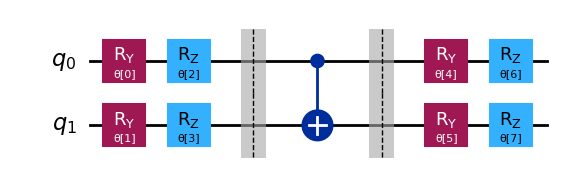

In [3]:
# 2. Create the Ansatz
ansatz = EfficientSU2(num_qubits=2, reps=1, entanglement="linear", insert_barriers=True)

# Decompose just to see what it looks like inside
ansatz.decompose().draw("mpl")

### Note: The Hybrid Loop

VQE is a **Hybrid Algorithm**, meaning it combines a Quantum Processor (QPU) with a Classical Processor (CPU).

1.  **QPU Step (Estimator):** The quantum computer prepares the state $|\psi(\theta)\rangle$ and measures the expectation value of the Hamiltonian (the Energy).
    $$ E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle $$
2.  **CPU Step (Optimizer):** A classical optimizer (like **COBYLA**) looks at the energy calculated by the QPU. It suggests new parameters $\theta$ to try and make the energy lower.
3.  **Variational Principle:** Physics guarantees that the calculated energy will always be **greater than or equal to** the true ground state energy ($E_{ground} \le E(\theta)$). 

**In the following task**, we define this cost function. We use `ISA` (Instruction Set Architecture) transpilation to ensure our circuit runs on the specific fake backend we chose.

## Task 3: The VQE Loop (Cost Function)

We need a python function that takes parameters `params` and returns the Energy. The classical optimizer will call this function repeatedly.

**Steps inside the function:**
1. Bind the `params` to the ansatz.
2. Use the `Estimator` primitive to calculate the expectation value $\langle H \rangle$.

In [6]:
# Setup Fake Backend and Estimator
backend = FakeManilaV2()
estimator = Estimator(backend=backend)

# Transpile for the backend (ISA circuits)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

def cost_func(params):
    """
    Calculates the energy of the Hamiltonian for a given set of parameters.
    """
    # 1. Pubs (Primitive Unified Blocs): A tuple of (circuit, observables, parameter_values)
    # Note: reshape params to make it compatible with the estimator input format
    pub = (ansatz_isa, hamiltonian_isa, params)
    
    # 2. Run Estimator
    job = estimator.run([pub])
    result = job.result()
    
    # 3. Extract Energy (The expectation value)
    energy = result[0].data.evs
    
    print(f"Energy: {energy:.5f}") # Print to track progress
    return energy

## Task 4: Run the Optimization

Now we use a classical optimizer `minimize` (from SciPy) to find the minimum energy.

**Your Task:** Run the cell to start the VQE loop.

In [7]:
# Initial random parameters
num_params = ansatz_isa.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

print(f"Starting VQE with {num_params} parameters...")

# Run optimization
result = minimize(cost_func, x0, method="COBYLA", options={"maxiter": 50})

print("\nOptimization Complete!")
print(f"Minimum Energy Found: {result.fun:.5f} Hartrees")
print(f"Target Energy (approx): -1.86 Hartrees")

Starting VQE with 8 parameters...
Energy: -0.94525
Energy: -1.07875
Energy: -1.01785
Energy: -1.10026
Energy: -0.76934
Energy: -0.90348
Energy: -1.10311
Energy: -1.05163
Energy: -1.07837
Energy: -1.26936
Energy: -1.17986
Energy: -1.26692
Energy: -1.31934
Energy: -1.14930
Energy: -1.33409
Energy: -1.37073
Energy: -1.29158
Energy: -1.42124
Energy: -1.36138
Energy: -1.57729
Energy: -1.61498
Energy: -1.57161
Energy: -1.60333
Energy: -1.50617
Energy: -1.61015
Energy: -1.62431
Energy: -1.60241
Energy: -1.60748
Energy: -1.62594
Energy: -1.62743
Energy: -1.62716
Energy: -1.63107
Energy: -1.63077
Energy: -1.62700
Energy: -1.62664
Energy: -1.64097
Energy: -1.62635
Energy: -1.62923
Energy: -1.64320
Energy: -1.64120
Energy: -1.63729
Energy: -1.62628
Energy: -1.63765
Energy: -1.63191
Energy: -1.63018
Energy: -1.64635
Energy: -1.63883
Energy: -1.62828
Energy: -1.62896
Energy: -1.64238

Optimization Complete!
Minimum Energy Found: -1.64635 Hartrees
Target Energy (approx): -1.86 Hartrees
